# Variables

In [1]:
ga_input = '/grid/home/nbourgeois/data/test_sequences/hidua/hidua.pep.fas' #sequence pep.fas Input
tissue = 'Brain_Cerebellum' # Tissue type for CoCoPuts
filename = 'test_git'

# Imports


## PyGAD

In [2]:
import os
cwd = os.getcwd()
pygad_loc = '/grid/home/nbourgeois/hmi_bifx_tools/codon_optimization'
os.chdir(pygad_loc)
import pygad
import numpy
import os
import sys
import Bio
import pandas as pd
from general_functions import *
from metrics import *
import hashlib
import subprocess
import time
os.chdir(cwd)


Using TensorFlow backend.


# Start

## Parameters

### Metrics

In [3]:
cai_on = True
bai_on = True
sps_on = False
cpg_on = False
pas_on = False


### Weights

In [4]:
cai_w = 1 *cai_on
bai_w = 1 *bai_on
sps_w = 1 *sps_on
cpg_w = 1 *cpg_on
pas_w = 1 *pas_on

In [5]:
global total_weight
total_weight = sum([cai_w,bai_w,sps_w,cpg_w,pas_w])

### Locations

In [6]:
cai_index_loc = os.path.join(pygad_loc,'CoCoPUTs_codon_usage/codon_usage/'+tissue+'.codon.txt')
bai_index_loc = os.path.join(pygad_loc,'CoCoPUTs_codon_usage/bicodon_usage/'+tissue+'.bicodon.txt')

codon_usage_table_loc = os.path.join(pygad_loc,'codon_usage.getex.txt')

# Algorithm

### Read in File

In [7]:
(keys, seqs) = readFasta(ga_input)
if len(seqs) == 1:
    aa_seq=str(seqs[0])

### Initialize Parameters
- gene_space
- codon_to_int dictionary

In [8]:
global codon_to_int

codon_to_int, gene_space = init_parameters(codon_usage_table_loc, aa_seq)
    
gene_space_int = [[codon_to_int[x] for x in y] for y in gene_space]

# Fitness Function

In [9]:
def fitness_func(solution, solution_idx):
    
    if not type(solution) is str:
        seq_aa = ''.join([codon_to_int[x] for x in solution])
    else:
        seq_aa = solution
#     print(solution_idx)

    tmp_dict = {}
    
    #Check for redundancy
    if seq_aa in all_sols.keys():
        fitness = all_sols[seq_aa]['fitness']

    else:
        fitness = 0
        
        if cai_on:
            cai = get_cai(seq_aa, cai_index_loc)
            fitness += cai*cai_w
            tmp_dict['cai'] = cai
        
        if bai_on:
            bai = get_bai(seq_aa, bai_index_loc)
            fitness += bai*bai_w
            tmp_dict['bai'] = bai
            
        if cpg_on:
            cpg = get_cpg(seq_aa)
            fitness += cpg*cpg_w
            tmp_dict['cpg'] = cpg

        if sps_on:
            sps = get_sps(seq_aa)
            print('SPS retuned.')

            fitness += sps*sps_w
            tmp_dict['sps'] = sps

        if pas_on:
            pas = get_pas(seq_aa)
            fitness += pas*pas_w
            tmp_dict['pas'] = pas

        fitness = fitness/total_weight
        tmp_dict['fitness'] = fitness
        all_sols[seq_aa] = tmp_dict
        
    
    return fitness

    

# Genetic Algorithm

In [10]:
"""
Given the following function:
    y = f(w1:w6) = w1x1 + w2x2 + w3x3 + w4x4 + w5x5 + 6wx6
    where (x1,x2,x3,x4,x5,x6)=(4,-2,3.5,5,-11,-4.7) and y=44
What are the best values for the 6 weights (w1 to w6)? We are going to use the genetic algorithm to optimize this function.
"""

# def convert_aa_int():
    
desired_output = 1 # Function output.
all_sols = {}

fitness_function = fitness_func

num_generations = 100 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.

sol_per_pop = 20 

parent_selection_type = "sss" # Type of parent selection.
keep_parents = 5 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

crossover_type = "two_points" # Type of the crossover operator.

# Parameters of the mutation operation.
mutation_type = "random" # Type of the mutation operator.
mutation_percent_genes = 5 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists or when mutation_type is None.

last_fitness = 0

def callback_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.

num_genes = len(gene_space)
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop, 
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=callback_generation,
                       gene_type=int,
                       gene_space=gene_space_int,
)


Generation = 1
Fitness    = 0.44858122326969396
Change     = 0.44858122326969396
Generation = 2
Fitness    = 0.454834124084321
Change     = 0.006252900814627038
Generation = 3
Fitness    = 0.460805524813045
Change     = 0.005971400728723986
Generation = 4
Fitness    = 0.46175832332858
Change     = 0.000952798515535036
Generation = 5
Fitness    = 0.4728704909693485
Change     = 0.0111121676407685
Generation = 6
Fitness    = 0.4728704909693485
Change     = 0.0
Generation = 7
Fitness    = 0.477216923314706
Change     = 0.004346432345357476
Generation = 8
Fitness    = 0.483776465414567
Change     = 0.006559542099860982
Generation = 9
Fitness    = 0.492551541121021
Change     = 0.008775075706454027
Generation = 10
Fitness    = 0.493175693988738
Change     = 0.0006241528677169983
Generation = 11
Fitness    = 0.4996621983852295
Change     = 0.00648650439649151
Generation = 12
Fitness    = 0.4996621983852295
Change     = 0.0
Generation = 13
Fitness    = 0.506770604937374
Change     = 0.0071084

/data/software/anaconda3/envs/bfx-gpu/lib/python3.7/site-packages/pygad/pygad.py:3105: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


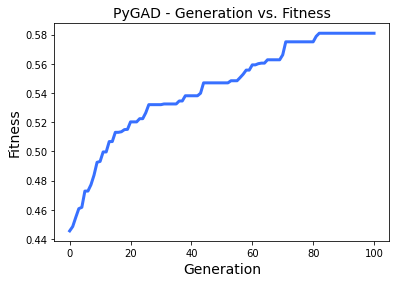

Parameters of the best solution : [11 53 37  3 58 37 55 46 45  7  7 45  5  7 47 33  2  3 45 45 38 36 15 44
 39 46 31 45 36 20  3 15 20 12 28 45 44 53 44  3 51 38  5 58 59  0 51 52
 56 43 61  1 49 36 36  4 37 21 34 23 47 28 23 17 15  3 57 51 29 23 22  3
 25  7 44 17 12 61 44 15 38 21 55 61  8 27 22 15 59 42 21 51  7  5 31  7
 15 41 41 58 61 57 42 60 59 62  3 56 17 25  1 41 20  7 29 61 16  5 28  7
  5 59 31 25 23  5  4 37 62  0 31  5 11 61 57 45 32 61 20  1 40 28  1 31
 29 27 23 23 13  1 31 51 26 29  7 15 32 35  7 45 53 55 17  8 61 53 16 63
  5 45 20 15 57 27 51 24  1 30 42 51 25 31 38 29 21 20 28  0 28 25 12 33
 11 41 11 22 61  0  5 24 16 16 28 45 48 56 30 63  7 55 46 45 34 37 44  7
 53  3 61 61 36 62 29 33  1 21 41 38 37 52 33 36  3 57 51 61  7  7 53 21
 48 20 28 61 41 25  1  1 43 60 30 44 62 13 53  2 29 17  9 33  7 21 55 27
 62 45 55 33 57  9 56  8  7 31 22 31 27 15 15 44 22 23  9 55 22  4  0 39
 27  1 45 28 42 37  9 17 25 29 31 45 29 39  7 13 63 51 33  4 36 23 37 51
 59 44 29 15 40 1

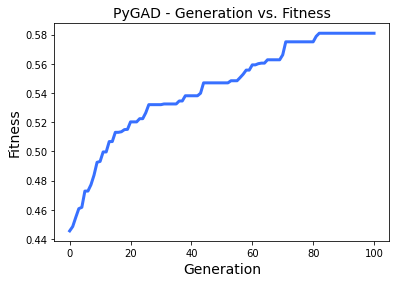

CPU times: user 7.2 s, sys: 40.1 s, total: 47.3 s
Wall time: 6min 15s


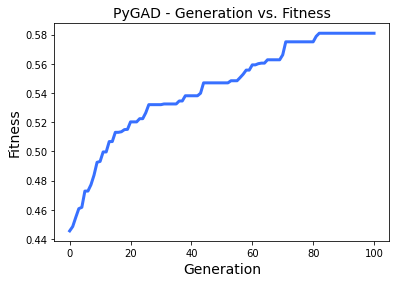

In [11]:
%%time

# Running the GA to optimize the parameters of the function.
ga_instance.run()

# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
seq_aa = ''.join([codon_to_int[x] for x in solution])
print("NT Sequence of the best solution : {seq_aa}".format(seq_aa=seq_aa))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# # prediction = numpy.sum(numpy.array(function_inputs)*solution) Replace
# print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Saving the GA instance.
 # The filename to which the instance is saved. The name is without extension.
ga_instance.save(filename=filename)

# Loading the saved GA instance.
loaded_ga_instance = pygad.load(filename=filename)
loaded_ga_instance.plot_result()